In [33]:
import pandas as pd
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy 
import math
from lifelines import KaplanMeierFitter
import ipywidgets as widgets
from IPython.display import clear_output
from lifelines.plotting import plot_lifetimes

In [34]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
#Add some formatting options so you can always see your data
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('max_colwidth', 100000)

In [35]:
sepsis_data = pd.read_csv("./sepsis3-df-no-exclusions.csv")
sepsis_data.head()

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,first_service,hospital_expire_flag,thirtyday_expire_flag,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
0,55973,200001,152234,1,2181-11-25 19:06:12,2181-11-28 20:59:25,metavision,2181-11-18 11:10:00,7.330694,BLOOD CULTURE,0.0,2181-11-18 00:00:00,2181-11-24 00:12:00,1,61.0499,F,0,ASIAN - ASIAN INDIAN,0,0,0,1,0,1,170.18,61.0,21.062640,MED,0,0,3.0786,15.901389,0,0,0,0,0,0,0,0,3,0,6,7,3,2,1.0,0.0,1.0,1,0,0,0,1,0,0,1,True,True,True,1,1
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 21:02:00,-0.049954,BLOOD CULTURE,1.0,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.2940,M,1,WHITE,1,0,0,0,0,0,177.80,77.0,24.357192,SURG,0,0,5.8884,20.081944,1,1,0,0,0,1,1,1,0,1,6,3,4,2,1.0,0.0,1.0,0,0,0,1,0,0,0,1,True,True,True,1,1
2,10950,200006,189514,1,2159-09-03 11:28:14,2159-09-04 19:08:10,carevue,NaN,NaN,NaN,NaN,NaN,2159-09-03 09:00:00,1,54.0710,M,1,OTHER,0,0,0,1,0,1,165.10,82.4,30.229646,MED,0,0,1.3194,2.304167,0,0,0,0,0,0,0,0,-5,1,1,2,2,2,1.0,0.0,1.0,1,0,0,1,0,0,0,0,True,False,False,0,0
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,NaN,NaN,NaN,NaN,NaN,0,43.3439,M,1,WHITE,1,0,0,0,0,0,177.80,126.0,39.857223,CMED,0,0,1.2914,3.239583,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,NaN,NaN,NaN,2189-11-30 00:00:00,NaN,0,47.5548,F,0,WHITE,1,0,0,0,0,0,161.29,87.2,33.519814,CSURG,0,0,2.1549,6.177083,0,0,0,0,0,0,0,0,-4,1,3,4,4,2,1.0,0.0,1.0,0,0,1,1,0,0,0,0,False,False,True,0,1


In [36]:
#sepsis_data.info()

## Preprocessing: removing patients with metastatic cancer and diabetes + removing patients with null factors in what we're analyzing

In [37]:
sepsis_data.intime = pd.to_datetime(sepsis_data.intime)
sepsis_data.outtime = pd.to_datetime(sepsis_data.outtime)

### Preprocessing pt 1
# Remove patients with metastatic cancer and diabetes
sepsis_data_rm = sepsis_data[(sepsis_data["diabetes"] == 0) & (sepsis_data["metastatic_cancer"] == 0)]

### Preprocessing pt 2
# Remove patients with null values in factors we are analyzing.
sepsis_mod = sepsis_data_rm.dropna(subset=["age","gender","weight","race_white","race_black","race_hispanic","race_other"]) # Could change later. 

### Preprocessing pt 3
# Set patients with null values in suspected_infection_time_poe_days to 0. This means they were diagnosed before
# coming into the hospital, so we assume they were diagnosed as soon as they come in.

sepsis_mod = sepsis_mod.replace({'suspected_infection_time_poe_days': np.nan}, value=0.0)
display(sepsis_mod.head())

### Preprocessing pt 4 
# Set patients with negative values of suspected infection time to 0.
sepsis_mod.loc[~(sepsis_mod['suspected_infection_time_poe_days'] > 0), 'suspected_infection_time_poe_days']= 0


#print(sepsis_mod[sepsis_mod['race_white']==1].shape) ====> 24013
#print(sepsis_mod[sepsis_mod['race_black']==1].shape) # ====> 2611
#print(sepsis_mod[sepsis_mod['race_hispanic']==1].shape) # ====> 1008
#print(sepsis_mod[sepsis_mod['race_other']==1].shape) # ====> 5230
# print(sepsis_mod.columns)

,subject_id,icustay_id,hadm_id,excluded,intime,outtime,dbsource,suspected_infection_time_poe,suspected_infection_time_poe_days,specimen_poe,positiveculture_poe,antibiotic_time_poe,blood_culture_time,blood_culture_positive,age,gender,is_male,ethnicity,race_white,race_black,race_hispanic,race_other,metastatic_cancer,diabetes,height,weight,bmi,first_service,hospital_expire_flag,thirtyday_expire_flag,icu_los,hosp_los,sepsis_angus,sepsis_martin,sepsis_explicit,septic_shock_explicit,severe_sepsis_explicit,sepsis_nqf,sepsis_cdc,sepsis_cdc_simple,elixhauser_hospital,vent,sofa,lods,sirs,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,exclusion_secondarystay,exclusion_nonadult,exclusion_csurg,exclusion_carevue,exclusion_early_suspicion,exclusion_late_suspicion,exclusion_bad_data,composite_outcome,blood culture,suspicion_poe,abx_poe,sepsis-3,sofa>=2
1,27513,200003,163557,1,2199-08-02 19:50:04,2199-08-08 17:09:18,carevue,2199-08-02 21:02:00,-0.049954,BLOOD CULTURE,1.0,2199-08-02 00:00:00,2199-08-02 21:02:00,1,48.2940,M,1,WHITE,1,0,0,0,0,0,177.80,77.0,24.357192,SURG,0,0,5.8884,20.081944,1,1,0,0,0,1,1,1,0,1,6,3,4,2,1.0,0.0,1.0,0,0,0,1,0,0,0,1,True,True,True,1,1
3,20707,200007,129310,1,2109-02-17 10:03:37,2109-02-18 17:03:12,carevue,NaN,0.000000,NaN,NaN,NaN,NaN,0,43.3439,M,1,WHITE,1,0,0,0,0,0,177.80,126.0,39.857223,CMED,0,0,1.2914,3.239583,0,0,0,0,0,0,0,0,0,0,1,2,2,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,False,False,False,0,0
4,29904,200009,129607,1,2189-11-30 10:34:32,2189-12-02 14:17:37,carevue,NaN,0.000000,NaN,NaN,2189-11-30 00:00:00,NaN,0,47.5548,F,0,WHITE,1,0,0,0,0,0,161.29,87.2,33.519814,CSURG,0,0,2.1549,6.177083,0,0,0,0,0,0,0,0,-4,1,3,4,4,2,1.0,0.0,1.0,0,0,1,1,0,0,0,0,False,False,True,0,1
6,93535,200011,121562,1,2188-08-06 01:39:24,2188-08-07 16:50:53,metavision,2188-08-05 21:41:00,0.165556,URINE,1.0,2188-08-05 00:00:00,2188-08-05 21:41:00,1,84.2318,F,0,WHITE,1,0,0,0,0,0,147.32,101.4,46.721259,MED,0,0,1.6330,1.847917,0,0,0,0,0,0,1,1,8,1,3,4,1,1,0.0,0.0,1.0,1,0,0,0,0,0,0,0,True,True,True,1,1
7,28448,200012,177527,1,2153-12-23 05:12:55,2153-12-23 15:55:54,carevue,2153-12-23 00:30:00,0.196470,BLOOD CULTURE,0.0,2153-12-23 00:00:00,2153-12-23 00:30:00,0,32.9891,F,0,ASIAN,0,0,0,1,0,0,NaN,51.2,NaN,MED,0,0,0.4465,0.425694,0,1,0,0,0,1,0,0,0,0,1,1,3,2,1.0,0.0,1.0,0,0,0,1,0,0,0,0,True,True,True,0,0


In [38]:
time_baseline = sepsis_mod.sort_values(by='intime').intime.iloc[0]

sepsis_mod['corrected_intime'] = (sepsis_mod.intime - time_baseline).dt.total_seconds()
sepsis_mod['corrected_outtime'] = (sepsis_mod.outtime - time_baseline).dt.total_seconds()
sepsis_mod['stay_duration_sec'] = (sepsis_mod.corrected_outtime - sepsis_mod.corrected_intime)
sepsis_mod['stay_duration_days'] = sepsis_mod.stay_duration_sec/(3600*24)

### For the calculation of TTE for patients, factoring in how long it took to discover they had sepsis.

sepsis_mod['known_sepsis_time'] = sepsis_mod.stay_duration_days - sepsis_mod.suspected_infection_time_poe_days 
sepsis_mod.loc[~(sepsis_mod['known_sepsis_time'] > 0), 'known_sepsis_time']= 0 # Sometimes will be negative; adjust to 0.


#sepsis_mod[['suspected_infection_time_poe_days','stay_duration_days','known_sepsis_time']]
#sepsis_mod = sepsis_mod.sort_values(by='corrected_intime')

In [39]:


def qth_survival_time(q, survival_function, cdf=False):
    """
    Expects a Pandas series, returns the time when the qth probability is reached.
    """
    if cdf:
        if survival_function.iloc[0] > q:
            return np.inf
        v = (survival_function <= q).idxmin(0)
    else:
        if survival_function.iloc[-1] > q:
            return np.inf
        v = (survival_function <= q).idxmax(0)
        
    return(v)



In [40]:

# Do preprocessing for what will become different data subsets.

sepsis_mod_black = sepsis_mod[sepsis_mod['race_black']==1]
sepsis_mod_hispanic = sepsis_mod[sepsis_mod['race_hispanic']==1]
sepsis_mod_white = sepsis_mod[sepsis_mod['race_white']==1]
sepsis_mod_other = sepsis_mod[sepsis_mod['race_other']==1]

sepsis_mod_any_male = sepsis_mod[sepsis_mod['gender']=="M"]
sepsis_mod_any_female = sepsis_mod[sepsis_mod['gender']=='F']

sepsis_mod_black_male = sepsis_mod[(sepsis_mod['race_black']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_black_female = sepsis_mod[(sepsis_mod['race_black']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_hispanic_male  = sepsis_mod[(sepsis_mod['race_hispanic']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_hispanic_female = sepsis_mod[(sepsis_mod['race_hispanic']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_white_male = sepsis_mod[(sepsis_mod['race_white']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_white_female = sepsis_mod[(sepsis_mod['race_white']==1) & (sepsis_mod['gender']=='F')]
sepsis_mod_other_male = sepsis_mod[(sepsis_mod['race_other']==1) & (sepsis_mod['gender']=='M')]
sepsis_mod_other_female = sepsis_mod[(sepsis_mod['race_other']==1) & (sepsis_mod['gender']=='F')]

sepsis_mod_normal = sepsis_mod


# Initialize what will eventually become dropdown menus

global race 
race = "Any"
global age 
age = 25
global weight 
weight = 100
global gender 
gender = "Any"


def changeDiagram(race, age, weight, gender, diagnosis=True):
    #print("calling changeDiagram with race = {}, age = {}, weight = {}, gender = {}".format(race, age, weight, gender))
    
    if race == "African American" and gender == "Male":   
        mod_adjustment = sepsis_mod_black_male[(sepsis_mod_black_male['age'] >= age) & (sepsis_mod_black_male['weight'] >= weight)]        
    elif race == "African American" and gender == "Female":
        mod_adjustment = sepsis_mod_black_female[(sepsis_mod_black_female['age'] >= age) & (sepsis_mod_black_female['weight'] >= weight)]
    elif race == "African American" and gender == "Any":
        mod_adjustment = sepsis_mod_black[(sepsis_mod_black['age'] >= age) & (sepsis_mod_black['weight'] >= weight)]
        
    elif race == "Hispanic" and gender == "Male":
        mod_adjustment = sepsis_mod_hispanic_male[(sepsis_mod_hispanic_male['age'] >= age) & (sepsis_mod_hispanic_male['weight'] >= weight)]
    elif race == "Hispanic" and gender == "Female":
        mod_adjustment = sepsis_mod_hispanic_female[(sepsis_mod_hispanic_female['age'] >= age) & (sepsis_mod_hispanic_female['weight'] >= weight)]
    elif race == "Hispanic" and gender == "Any":
        mod_adjustment = sepsis_mod_hispanic[(sepsis_mod_hispanic['age'] >= age) & (sepsis_mod_hispanic['weight'] >= weight)]
        
    elif race == "White" and gender == "Male":
        mod_adjustment = sepsis_mod_white_male[(sepsis_mod_white_male['age'] >= age) & (sepsis_mod_white_male['weight'] >= weight)]
    elif race == "White" and gender == "Female":
        mod_adjustment = sepsis_mod_white_female[(sepsis_mod_white_female['age'] >= age) & (sepsis_mod_white_female['weight'] >= weight)]
    elif race == "White" and gender == "Any":
        mod_adjustment = sepsis_mod_white[(sepsis_mod_white['age'] >= age) & (sepsis_mod_white['weight'] >= weight)]       
        
    elif race == "Other" and gender == "Male":
        mod_adjustment = sepsis_mod_other_male[(sepsis_mod_other_male['age'] >= age) & (sepsis_mod_other_male['weight'] >= weight)]
    elif race == "Other" and gender == "Female":
        mod_adjustment = sepsis_mod_other_female[(sepsis_mod_other_female['age'] >= age) & (sepsis_mod_other_female['weight'] >= weight)]
    elif race == "Other" and gender == "Any":
        mod_adjustment = sepsis_mod_other[(sepsis_mod_other['age'] >= age) & (sepsis_mod_other['weight'] >= weight)]
        
    elif race == "Any" and gender == "Male":
        mod_adjustment = sepsis_mod_any_male[(sepsis_mod_any_male['age'] >= age) & (sepsis_mod_any_male['weight'] >= weight)]
    elif race == "Any" and gender == "Female":
        mod_adjustment = sepsis_mod_any_female[(sepsis_mod_any_female['age'] >= age) & (sepsis_mod_any_female['weight'] >= weight)]
    elif race == "Any" and gender == "Any":
        mod_adjustment = sepsis_mod_normal[(sepsis_mod_normal['age'] >= age) & (sepsis_mod_normal['weight'] >= weight)]
        

    
    TTE = mod_adjustment['stay_duration_days']
    TTE_diagnosis = mod_adjustment['known_sepsis_time']
    
    EventFlg = mod_adjustment['hospital_expire_flag']
    
    kmf = KaplanMeierFitter()
    kmfDiagnosis = KaplanMeierFitter()
    
    
    
    if not diagnosis:
        return kmf.fit(TTE, event_observed=EventFlg,label='Full Data')
    else:
        return kmfDiagnosis.fit(TTE_diagnosis, event_observed=EventFlg,label='Full Data')
    

### PLOT LIFELINES NOT WORKING!!! WTF

In [41]:


#This function takes the following paramaters:
#plot_lifetimes(Time-To-Event-Series, event_observed=Event-Observed-Series)
# plt.xlabel("time")
# plt.title("Timespans of patient mortality")
#plot_lifetimes(TTE, event_observed=EventFlg) <-- THIS THROWS A KEY = 0 ERROR :/

In [42]:
%matplotlib inline


# Slider Demo


Using the slider widget to control visual properties of your plot.

In this example, a slider is used to choose the frequency of a sine
wave. You can control many continuously-varying properties of your plot in
this way.



In [43]:
r = widgets.Dropdown(
    options=['Any','White', 'African American', 'Hispanic', 'Other'],
    value='Any',
    description='Race:',
)


a = widgets.IntSlider(
    value=25,
    min=10,
    max=80,
    step=1,
    description='Age:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


w = widgets.IntSlider(
    value = 100,
    min = 50, 
    max = 300,
    step = 1,
    description="Weight:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
      

)


g = widgets.Dropdown(
    options=['Any','Male', 'Female'],
    value='Any',
    description='Gender:',
)


Dropdown(description='Race:', index=1, options=('Any', 'White', 'African American', 'Hispanic', 'Other'), valu…

IntSlider(value=17, continuous_update=False, description='Age:', max=80, min=10)

IntSlider(value=72, continuous_update=False, description='Weight:', max=300, min=50)

Dropdown(description='Gender:', options=('Any', 'Male', 'Female'), value='Any')

A patient with these conditions is 50% likely to survive after 31.109930555555554 days.
After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after 32.413090277777776 days.


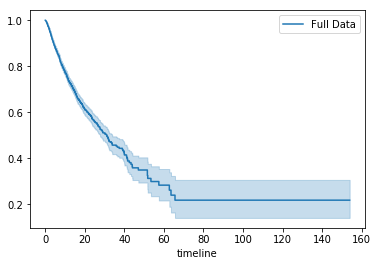

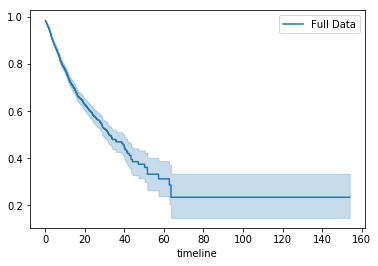

In [44]:
def on_change_race(change):
    if change['type'] == 'change' and change['name'] == 'value':
        race = change['new']
        clear_output()
        display(r,a,w,g)
        age = a.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        
        
        # Generate a new Kaplan Meier curve here. 

r.observe(on_change_race)

#display(r)


def on_change_age(change):
    if change['type'] == 'change' and change['name'] == 'value':
        age = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        gender = g.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))   
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        # Generate a new Kaplan Meier curve here. 

a.observe(on_change_age)


def on_change_weight(change):
    if change['type'] == 'change' and change['name'] == 'value':
        weight = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        weight = w.value
        age = a.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        new_plot.plot()
        new_plot_diagnosis.plot()
        
w.observe(on_change_weight)


def on_change_gender(change):
    if change['type'] == 'change' and change['name'] == 'value':
        gender = change['new']
        clear_output()
        display(r,a,w,g)
        race = r.value
        age = a.value
        weight = w.value
        new_plot = changeDiagram(race,age,weight,gender, False)
        new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)
        
        print("""A patient with these conditions is 50% likely to survive after {} days.""".format(qth_survival_time(.5,new_plot.survival_function_[new_plot.survival_function_.columns[0]])))
        
        print("After adjusting for late diagnosis times, the patient with these conditions would have been 50% likely to survive after {} days.".format(qth_survival_time(.5,new_plot_diagnosis.survival_function_[new_plot.survival_function_.columns[0]])))
        
        new_plot.plot()
        new_plot_diagnosis.plot()

g.observe(on_change_gender)




        
display(r,a, w, g)

new_plot = changeDiagram(race,age,weight,gender, False)
new_plot_diagnosis = changeDiagram(race,age,weight,gender, True)







